In [ ]:
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Assignment_Vanshita_Arya/Quantzig - Campus Hiring - DS Dataset 1.xlsx")

# Customer Segment Analysis: Identify different customer segments based on their booking behaviour, demographics, and other relevant factors.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                  total_nights   lead_time         adr  \
customer_segment                                         
0                     2.682913   50.970722   89.069894   
1                     3.804929   75.831564  142.248918   
2                     1.925984   30.786352   64.445997   
3                     4.718407  249.599474   89.566078   

                  total_of_special_requests  is_repeated_guest  
customer_segment                                                
0                                  0.220243                0.0  
1                                  1.516419                0.0  
2                                  0.628346                1.0  
3                                  0.265450                0.0  


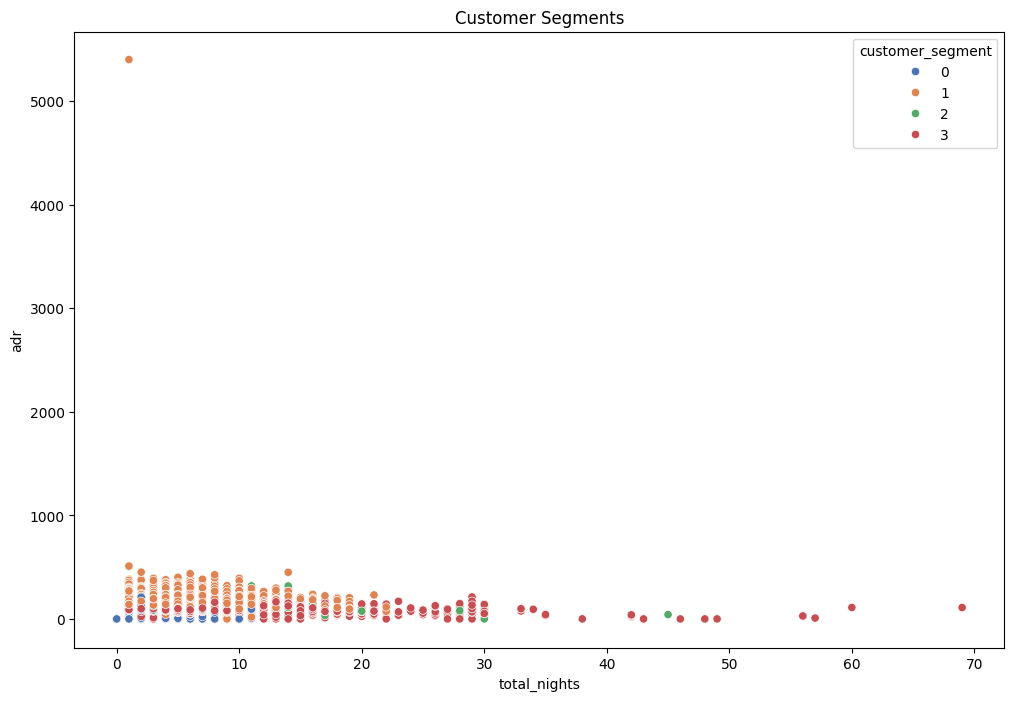

In [ ]:
segmentation_features = ['total_nights', 'lead_time', 'adr', 'total_of_special_requests', 'is_repeated_guest']

# Calculate total nights
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Prepare the data for clustering
X = df[segmentation_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['customer_segment'] = kmeans.fit_predict(X_scaled)



# Analyze segment characteristics
segment_analysis = df.groupby('customer_segment')[segmentation_features].mean()
print(segment_analysis)

# # Calculate the correlation matrix
# correlation_matrix = X.corr()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='total_nights', y='adr', hue='customer_segment', palette='deep')
plt.title('Customer Segments')
plt.show()

**Explanation:**

We select relevant features for segmentation based on booking behavior and customer characteristics.

We use K-means clustering to identify 4 distinct customer segments.

We analyze the characteristics of each segment by looking at the mean values of the segmentation features.

We visualize the segments using a scatter plot of total nights vs. ADR.

# Pricing Drivers Identification: Analyze the factors that drive room pricing,including demand, and other factors which might deem fit.

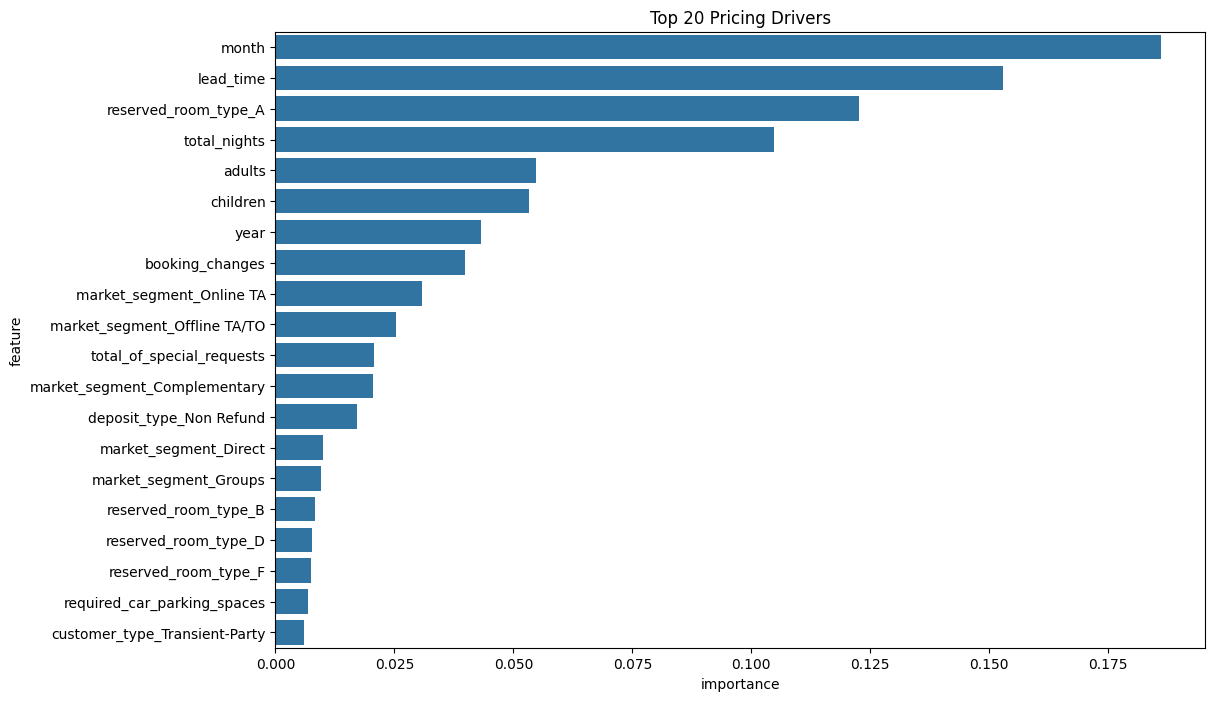

In [ ]:
# Calculate total nights
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Select potential pricing drivers
price_drivers = ['lead_time', 'total_nights', 'adults', 'children', 'babies',
                 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
                 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests',
                 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                 'deposit_type', 'customer_type', 'year', 'month']

# Create year and month features
df['year'] = df['arrival_date_year']
df['month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month
# print(df.head())
# Prepare the data
# print(df.head())
X = pd.get_dummies(df[price_drivers], columns=['market_segment', 'distribution_channel',
                                               'reserved_room_type', 'assigned_room_type',
                                               'deposit_type', 'customer_type'])
# print(X.head())

y = df['adr']

# # Store column names before imputation
X_columns = X.columns  # Store column names here

# # Handle missing values using imputation
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill missing values with the mean
X = imputer.fit_transform(X) # Apply the imputer to fill NaNs

# # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


# # Get feature importances
# # Use the stored column names (X_columns)
feature_importance = pd.DataFrame({'feature': X_columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# # Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Pricing Drivers')
plt.show()

**Explanation:**

We select a wide range of potential pricing drivers based on the available data.

We use a Random Forest Regressor to model the relationship between these factors and the ADR.

We extract feature importances from the model to identify the most significant pricing drivers.

We visualize the top 20 pricing drivers using a bar plot.

# Pricing Strategy Development: Develop a pricing strategy that takes intoaccount customer segmentation and demand forecasting.

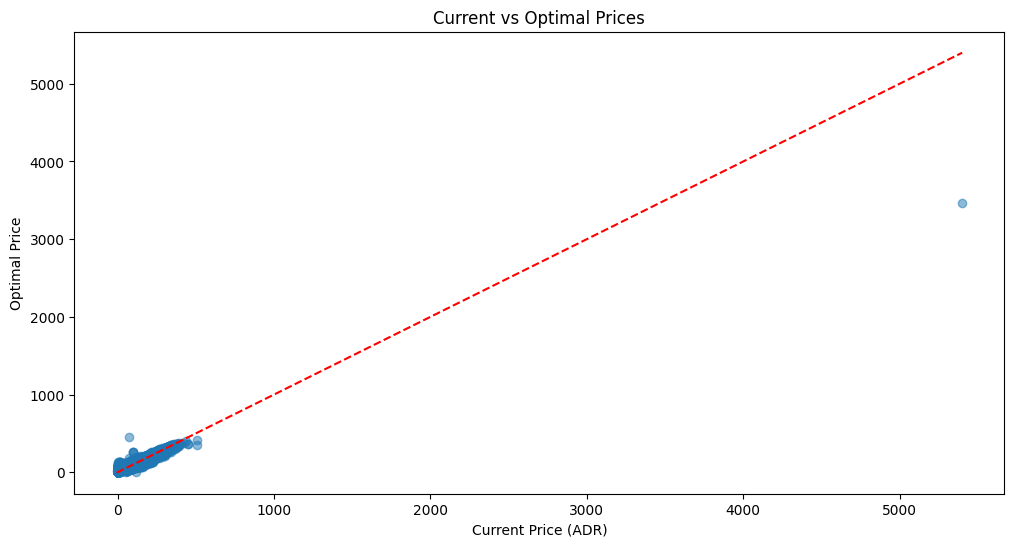

In [ ]:
# Prepare features for demand forecasting
demand_features = ['lead_time', 'total_nights', 'adults', 'children', 'babies',
                   'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
                   'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests',
                   'market_segment', 'distribution_channel', 'reserved_room_type',
                   'deposit_type', 'customer_type', 'year', 'month','customer_segment']

# Create year and month features
df['year'] = df['arrival_date_year']
df['month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month

# Prepare the data
X = pd.get_dummies(df[demand_features], columns=['market_segment', 'distribution_channel',
                                                 'reserved_room_type', 'deposit_type', 'customer_type'])
y = df['adr']

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill missing values with the mean
X = imputer.fit_transform(X) # Apply the imputer to fill NaNs

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

def calculate_optimal_price(row, base_price, demand_elasticity):
    # Convert the row to a NumPy array and reshape it for prediction
    row_array = np.array(row).reshape(1, -1)
    predicted_demand = rf_model.predict(row_array)[0]

    # Adjust base price based on predicted demand
    optimal_price = base_price * (1 + (predicted_demand - df['adr'].mean()) / df['adr'].std() * demand_elasticity)

    return optimal_price

# Set parameters (these should be tuned based on business knowledge and further analysis)
base_price = df['adr'].mean()
demand_elasticity = 0.5

# Calculate optimal prices
# Convert X to a DataFrame to use apply function
X_df = pd.DataFrame(X)
df['optimal_price'] = X_df.apply(lambda row: calculate_optimal_price(row, base_price, demand_elasticity), axis=1)

# Visualize current vs optimal prices
plt.figure(figsize=(12, 6))
plt.scatter(df['adr'], df['optimal_price'], alpha=0.5)
plt.plot([df['adr'].min(), df['adr'].max()], [df['adr'].min(), df['adr'].max()], 'r--')
plt.xlabel('Current Price (ADR)')
plt.ylabel('Optimal Price')
plt.title('Current vs Optimal Prices')
plt.show()

**Explanation:**

We use the Random Forest model to predict demand based on various features.

We develop a pricing strategy that adjusts the base price according to the predicted demand.

The calculate_optimal_price function determines the optimal price for each booking based on its characteristics and the predicted demand.

We visualize the current prices vs. the optimal prices to see how our strategy differs from the current pricing.


# Impact Quantification: Quantify the expected impact of the recommended pricing strategy on revenue and profitability.

Current Total Revenue: $42,723,497.53
Optimal Total Revenue: $42,776,190.74
Potential Revenue Increase: 0.12%
Current Estimated Profit: $25,634,098.52
Optimal Estimated Profit: $25,665,714.44
Potential Profit Increase: 0.12%


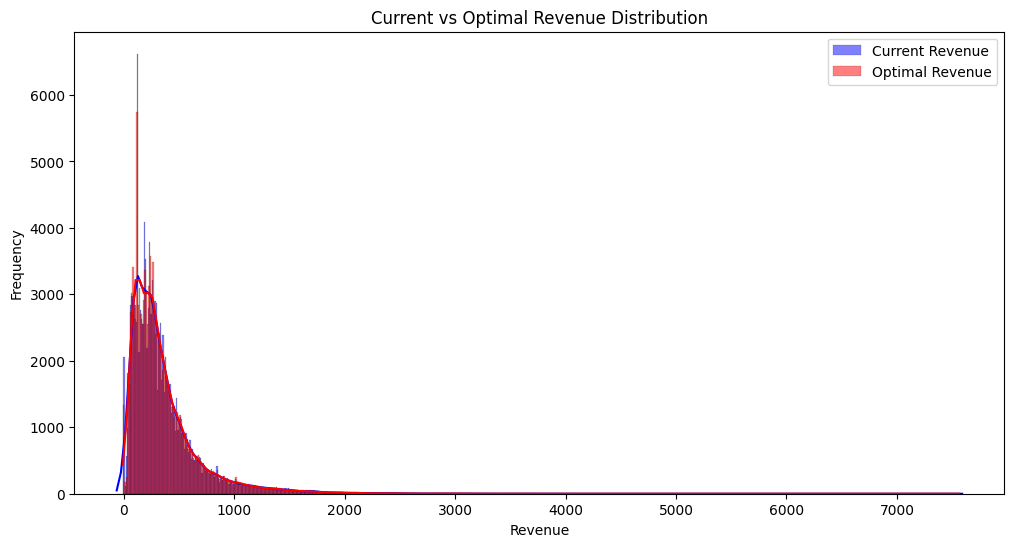

   customer_segment  current_revenue  optimal_revenue  revenue_increase
0                 0      13665092.65     1.368010e+07          0.109803
1                 1      16434929.79     1.645203e+07          0.104022
2                 2        584863.26     5.858795e+05          0.173764
3                 3      12038611.83     1.205819e+07          0.162613


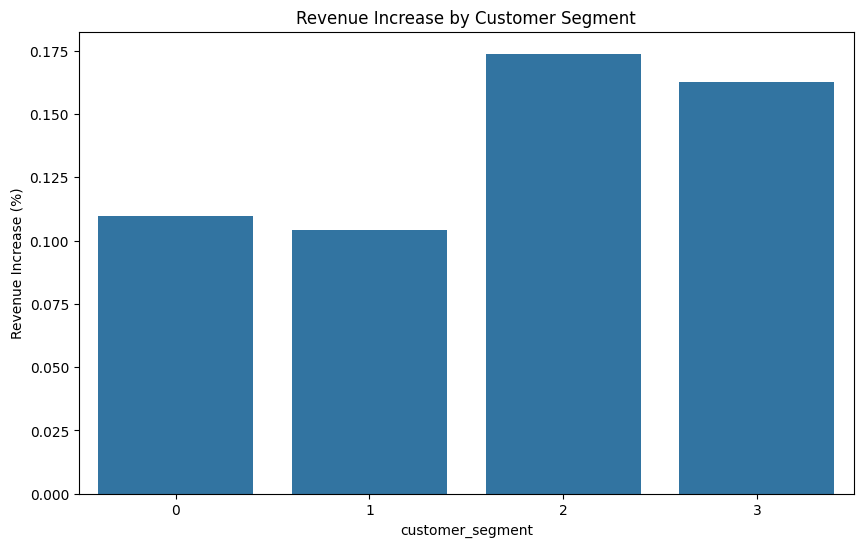

In [ ]:
# Calculate current and optimal revenue
df['current_revenue'] = df['adr'] * df['total_nights']
df['optimal_revenue'] = df['optimal_price'] * df['total_nights']

# Calculate total revenue and potential increase
total_current_revenue = df['current_revenue'].sum()
total_optimal_revenue = df['optimal_revenue'].sum()
revenue_increase = (total_optimal_revenue - total_current_revenue) / total_current_revenue * 100

print(f"Current Total Revenue: ${total_current_revenue:,.2f}")
print(f"Optimal Total Revenue: ${total_optimal_revenue:,.2f}")
print(f"Potential Revenue Increase: {revenue_increase:.2f}%")

# Assuming a 60% profit margin for simplicity
profit_margin = 0.6
current_profit = total_current_revenue * profit_margin
optimal_profit = total_optimal_revenue * profit_margin
profit_increase = (optimal_profit - current_profit) / current_profit * 100

print(f"Current Estimated Profit: ${current_profit:,.2f}")
print(f"Optimal Estimated Profit: ${optimal_profit:,.2f}")
print(f"Potential Profit Increase: {profit_increase:.2f}%")

# Visualize revenue distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='current_revenue', kde=True, color='blue', alpha=0.5, label='Current Revenue')
sns.histplot(data=df, x='optimal_revenue', kde=True, color='red', alpha=0.5, label='Optimal Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Current vs Optimal Revenue Distribution')
plt.legend()
plt.show()

# Analyze impact by customer segment
segment_impact = df.groupby('customer_segment').agg({
    'current_revenue': 'sum',
    'optimal_revenue': 'sum'
}).reset_index()

segment_impact['revenue_increase'] = (segment_impact['optimal_revenue'] - segment_impact['current_revenue']) / segment_impact['current_revenue'] * 100

print(segment_impact)

# Visualize impact by customer segment
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_segment', y='revenue_increase', data=segment_impact)
plt.title('Revenue Increase by Customer Segment')
plt.ylabel('Revenue Increase (%)')
plt.show()

**Explanation:**

We calculate the current and optimal revenue for each booking.

We compute the total current and optimal revenue, and calculate the potential revenue increase.

We estimate the impact on profit, assuming a fixed profit margin.

We visualize the distribution of current vs. optimal revenue to see how our pricing strategy affects the overall revenue structure.

We analyze and visualize the impact of our pricing strategy on different customer segments.